# Imbalanced Data

In [1]:
# https://www.openml.org/d/1220
# https://www.openml.org/d/1241
# https://www.openml.org/d/37
# https://www.openml.org/d/44

from sklearn.datasets import fetch_openml

data = fetch_openml(data_id=1220)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [3]:
df = pd.DataFrame(
    data['data'],
    columns=data['feature_names']
).astype(float)

df['target'] = pd.Series(data['target']).astype(int) 

In [4]:
df.sample(n=5)

,impression,ad_id,advertiser_id,depth,position,keyword_id,title_id,description_id,user_id,target
7245,1.0,21193219.0,35900.0,3.0,1.0,5.0,148.0,195.0,5003639.0,0
16040,1.0,21818926.0,37716.0,1.0,1.0,5846.0,33576.0,26849.0,1338874.0,0
35455,1.0,20192676.0,27961.0,1.0,1.0,39.0,131.0,440.0,2405920.0,0
16429,1.0,20001249.0,1381.0,2.0,2.0,361.0,5581.0,5890.0,0.0,0
35609,1.0,4241447.0,18226.0,2.0,2.0,8248.0,245292.0,213698.0,11225727.0,0


In [5]:
df.target.value_counts(normalize=True)

0    0.831581
1    0.168419
Name: target, dtype: float64

In [6]:
df.shape

(39948, 10)

In [11]:
for feature in df.columns[:-1].tolist():
  print(f'Cardinality of {feature}: {df[feature].value_counts().shape[0]:,}')

Cardinality of impression: 99
Cardinality of ad_id: 19,228
Cardinality of advertiser_id: 6,064
Cardinality of depth: 3
Cardinality of position: 3
Cardinality of keyword_id: 19,803
Cardinality of title_id: 25,321
Cardinality of description_id: 22,381
Cardinality of user_id: 30,114


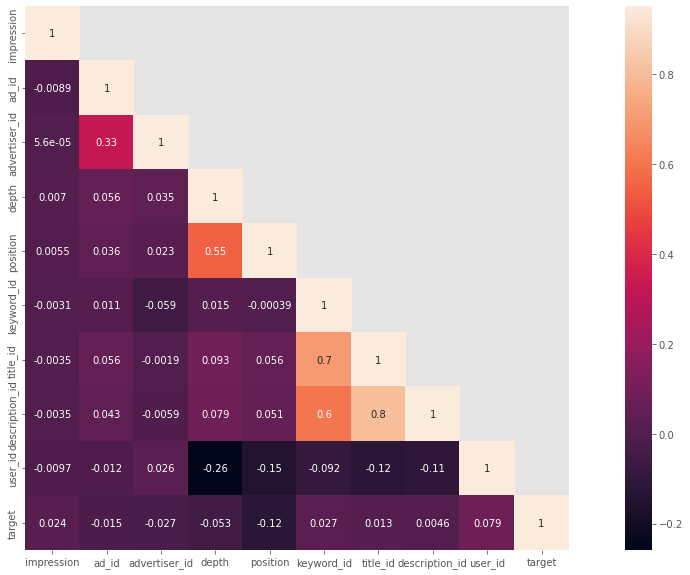

In [12]:
import seaborn as sns

cor_matt = df.corr()
mask = np.array(cor_matt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(cor_matt, mask=mask,vmax=.95, square=True,annot=True)

In [13]:
feature_names = data['feature_names']

x = df[feature_names]
y = df['target']

In [14]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.25, 
    random_state=42,
)

In [15]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.831581
1    0.168419
Name: target, dtype: float64
0    0.831581
1    0.168419
Name: target, dtype: float64


In [16]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score
from imblearn.metrics import geometric_mean_score


def predict_and_evalutate(x_train, y_train, x_test, y_test, sample_weight=None, title='Unweighted'):
    
    
    clf = Pipeline(
        [
            ('Embedder', RandomTreesEmbedding(n_estimators=10, max_leaf_nodes=20, random_state=42)), 
            ('Sclaer', MaxAbsScaler()),
            ('Classifier', LogisticRegression(solver='saga', max_iter=1000, random_state=42))
        ]
    )
    clf.fit(x_train, y_train, Classifier__sample_weight=sample_weight)
    y_test_pred = clf.predict(x_test)
    
    print(
        'Precision: {:.02%}, Recall: {:.02%}; G-mean: {:.02%} @  {}'.format(
            precision_score(y_test, y_test_pred),
            recall_score(y_test, y_test_pred),
            geometric_mean_score(y_test, y_test_pred),
            title
        )
    )
    
    return clf

In [17]:
clf = predict_and_evalutate(x_train, y_train, x_test, y_test)

Precision: 62.50%, Recall: 0.30%; G-mean: 5.45% @  Unweighted


In [18]:
y_train.mean()

0.16841894462801643

In [19]:
(1 - y_train.mean()) / y_train.mean()

4.937574316290131

The number of samples in the majority class is about five times those in the minority class.

In [20]:
sample_weight = (1 * (y_train == 0)) + (5 * (y_train == 1))

clf = predict_and_evalutate(x_train, y_train, x_test, y_test, 
                            sample_weight=sample_weight, title='Unweighted')

Precision: 24.78%, Recall: 13.38%; G-mean: 35.04% @  Unweighted


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [21]:
def calculate_feature_coeff(clf):
    return pd.DataFrame(
        {
            'Features': [
                f'EmbFeature{e}' 
                for e in range(len(clf[-1].coef_[0]))
            ] + ['Intercept'],
            'Coeff': list(
                clf[-1].coef_[0]
            ) + [clf[-1].intercept_[0]]
        }

    ).set_index('Features').tail(10)

In [22]:
calculate_feature_coeff(clf)

,Coeff
Features,
EmbFeature187,0.442264
EmbFeature188,-1.540624
EmbFeature189,-0.427968
EmbFeature190,0.596631
EmbFeature191,0.514360
EmbFeature192,0.866120
EmbFeature193,-0.925437
EmbFeature194,-0.150263
EmbFeature195,-0.294957


In [23]:
calculate_feature_coeff(clf).round(2).style.bar(
    subset='Coeff', 
    color='#999',
    align='zero'
)

,Coeff
Features,
EmbFeature187,0.440000
EmbFeature188,-1.540000
EmbFeature189,-0.430000
EmbFeature190,0.600000
EmbFeature191,0.510000
EmbFeature192,0.870000
EmbFeature193,-0.930000
EmbFeature194,-0.150000
EmbFeature195,-0.290000


In [24]:
df_coef_list = []
weight_options = [1, 2, 5]
for w in weight_options:
  print(f'\nMinority Class (Positive Class) Weight = Weight x {w}')
  sample_weight = (1 * (y_train == 0)) + (w * (y_train == 1))
  clf = predict_and_evalutate(
      x_train, y_train, x_test, y_test,
      sample_weight=sample_weight
  )
  df_coef = calculate_feature_coeff(clf)
  df_coef = df_coef.rename(columns={'Coeff': f'Coeff [w={w}]'})
  df_coef_list.append(df_coef)


Minority Class (Positive Class) Weight = Weight x 1
Precision: 62.50%, Recall: 0.30%; G-mean: 5.45% @  Unweighted

Minority Class (Positive Class) Weight = Weight x 2
Precision: 36.36%, Recall: 2.14%; G-mean: 14.57% @  Unweighted

Minority Class (Positive Class) Weight = Weight x 5
Precision: 24.78%, Recall: 13.38%; G-mean: 35.04% @  Unweighted


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [25]:
pd.concat(df_coef_list, axis=1).round(2).style.bar(
    subset=[f'Coeff [w={w}]' for w in weight_options], 
    color='#999',
    align='zero'
)

,Coeff [w=1],Coeff [w=2],Coeff [w=5]
Features,,,
EmbFeature187,0.090000,0.170000,0.440000
EmbFeature188,-1.180000,-1.370000,-1.540000
EmbFeature189,-0.170000,-0.260000,-0.430000
EmbFeature190,0.370000,0.450000,0.600000
EmbFeature191,0.370000,0.440000,0.510000
EmbFeature192,0.600000,0.760000,0.870000
EmbFeature193,-0.920000,-0.880000,-0.930000
EmbFeature194,-0.240000,-0.200000,-0.150000
EmbFeature195,-0.130000,-0.180000,-0.290000


In [28]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y, y_proba, ax, label):
    fpr, tpr, thr = roc_curve(y, y_proba)
    auc_value = auc(fpr, tpr)
    pd.DataFrame(
        {
            'FPR': fpr,
            'TPR': tpr
        }
    ).set_index('FPR')['TPR'].plot(
        label=label + f'; AUC = {auc_value:.3f}',
        kind='line',
        xlim=(0,1),
        ylim=(0,1),
        # color='k',
        ax=ax
    )
    return (fpr, tpr, auc_value)

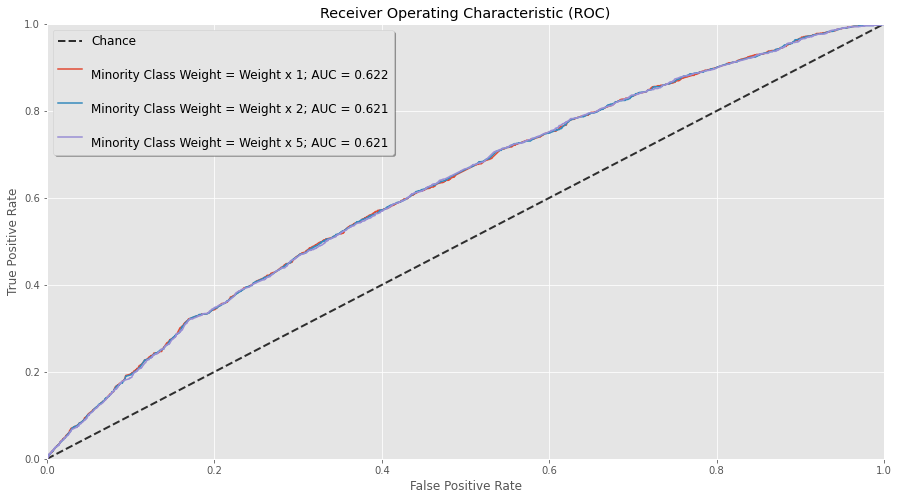

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8), sharey=False)

ax.plot(
    [0, 1], [0, 1], 
    linestyle='--', 
    lw=2, color='k',
    label='Chance', alpha=.8
)

for w in weight_options:

    sample_weight = (1 * (y_train == 0)) + (w * (y_train == 1))
    
    clf = Pipeline(
        [
            ('Embedder', RandomTreesEmbedding(n_estimators=20, max_leaf_nodes=20, random_state=42)), 
            ('Sclaer', MaxAbsScaler()),
            ('Classifier', LogisticRegression(solver='lbfgs', max_iter=2000, random_state=42))
        ]
    )
    clf.fit(x_train, y_train, Classifier__sample_weight=sample_weight)
    y_test_pred_proba = clf.predict_proba(x_test)[:,1]

    plot_roc_curve(
        y_test, y_test_pred_proba, 
        label=f'\nMinority Class Weight = Weight x {w}',
        ax=ax
    ) 

ax.set_title('Receiver Operating Characteristic (ROC)')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

ax.legend(ncol=1, fontsize='large', shadow=True)

fig.show()

# Sampling the training data

## Imbalanced Learn

In [30]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.pipeline import Pipeline

def sample_and_predict(x_train, y_train, x_test, y_test, sampler=None):
    
    if sampler:
        x_train, y_train = sampler.fit_resample(x_train, y_train)
    
    clf = Pipeline(
        [
            ('Embedder', RandomTreesEmbedding(n_estimators=10, max_leaf_nodes=20, random_state=42)), 
            ('Sclaer', MaxAbsScaler()),
            ('Classifier', LogisticRegression(solver='lbfgs', max_iter=2000, random_state=42))
        ]
    )
    clf.fit(x_train, y_train)
    y_test_pred_proba = clf.predict_proba(x_test)[:,1]
    
    return y_test, y_test_pred_proba

## Under-Sampling
### Random Under-Sampling

In [31]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

x_train_resampled, y_train_resampled = rus.fit_resample(x_train, y_train)

print(f'% of Positive Class = {y_train_resampled.mean():.2%}') 

% of Positive Class = 50.00%


In [32]:
clf = predict_and_evalutate(x_train_resampled, 
                            y_train_resampled,
                            x_test, y_test, 
                            title='Random Under Sampler'
)

Precision: 22.96%, Recall: 56.48%; G-mean: 58.99% @  Random Under Sampler


In [35]:
calculate_feature_coeff(clf).style.bar(subset=['Coeff'], color='#999', align='mid')

,Coeff
Features,
EmbFeature188,-0.068483
EmbFeature189,0.695364
EmbFeature190,0.375673
EmbFeature191,0.927944
EmbFeature192,0.462132
EmbFeature193,0.384885
EmbFeature194,-0.134408
EmbFeature195,0.623846
EmbFeature196,-0.338691


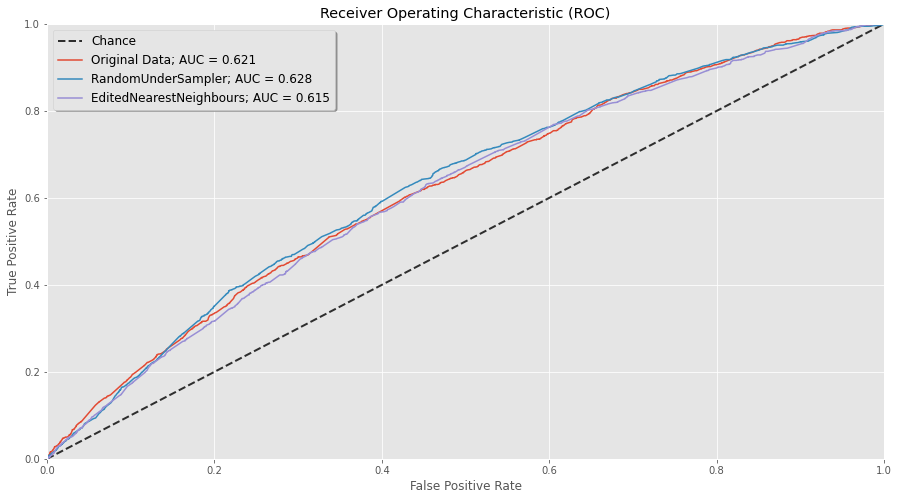

In [36]:
from sklearn.metrics import roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import EditedNearestNeighbours

fig, ax = plt.subplots(1, 1, figsize=(15, 8), sharey=False)

ax.plot(
    [0, 1], [0, 1], 
    linestyle='--', 
    lw=2, color='k',
    label='Chance', alpha=.8
)

# Original Data

y_test, y_test_pred_proba = sample_and_predict(x_train, y_train, x_test, y_test, sampler=None)

plot_roc_curve(
    y_test, y_test_pred_proba, 
    label='Original Data',
    ax=ax
) 


# RandomUnderSampler

rus = RandomUnderSampler(random_state=42)

y_test, y_test_pred_proba = sample_and_predict(x_train, y_train, x_test, y_test, sampler=rus)

plot_roc_curve(
    y_test, y_test_pred_proba, 
    label='RandomUnderSampler',
    ax=ax
) 

# EditedNearestNeighbours

nc = EditedNearestNeighbours(n_neighbors=5)

y_test, y_test_pred_proba = sample_and_predict(x_train, y_train, x_test, y_test, sampler=nc)

plot_roc_curve(
    y_test, y_test_pred_proba, 
    label='EditedNearestNeighbours',
    ax=ax
) 


ax.set_title(f'Receiver Operating Characteristic (ROC)')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

ax.legend(ncol=1, fontsize='large', shadow=True)

fig.show()

# Oversampling the minority class

## Random Over-Sampling

In [37]:
from imblearn.over_sampling import RandomOverSampler


ros = RandomOverSampler(random_state=0)

x_train_resampled, y_train_resampled = ros.fit_resample(x_train, y_train)

print(f'% of Positive Class = {y_train_resampled.mean():.2%}') 

% of Positive Class = 50.00%


In [38]:
clf = predict_and_evalutate(x_train_resampled, 
                            y_train_resampled, 
                            x_test, y_test, 
                            title='Random Over Sampler')

Precision: 21.97%, Recall: 58.38%; G-mean: 58.19% @  Random Over Sampler


## SMOTE

In [39]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)

x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

print(f'% of Positive Class = {y_train_resampled.mean():.2%}') 

% of Positive Class = 50.00%


In [40]:
predict_and_evalutate(x_train_resampled, 
                      y_train_resampled,
                      x_test, y_test, title='SMOTE')

Precision: 22.77%, Recall: 41.32%; G-mean: 54.40% @  SMOTE


Pipeline(steps=[('Embedder',
                 RandomTreesEmbedding(max_leaf_nodes=20, n_estimators=10,
                                      random_state=42)),
                ('Sclaer', MaxAbsScaler()),
                ('Classifier',
                 LogisticRegression(max_iter=1000, random_state=42,
                                    solver='saga'))])

In [41]:
from imblearn.over_sampling import BorderlineSMOTE
    
bsmote = BorderlineSMOTE(random_state=0)

x_train_resampled, y_train_resampled = bsmote.fit_resample(x_train, y_train)

print(f'% of Positive Class = {y_train_resampled.mean():.2%}') 

% of Positive Class = 50.00%


In [42]:
predict_and_evalutate(x_train_resampled,
                      y_train_resampled,
                      x_test, y_test, title='Borderline SMOTE')

Precision: 21.83%, Recall: 41.91%; G-mean: 54.01% @  Borderline SMOTE


Pipeline(steps=[('Embedder',
                 RandomTreesEmbedding(max_leaf_nodes=20, n_estimators=10,
                                      random_state=42)),
                ('Sclaer', MaxAbsScaler()),
                ('Classifier',
                 LogisticRegression(max_iter=1000, random_state=42,
                                    solver='saga'))])

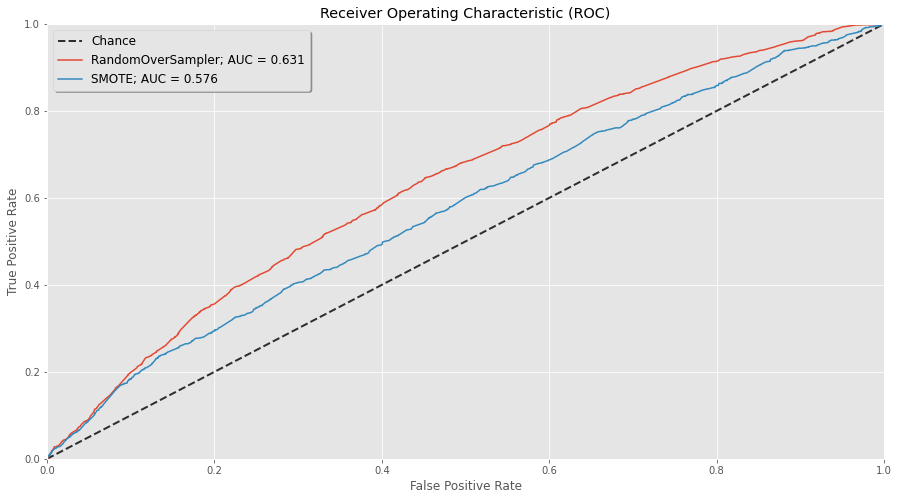

In [43]:
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

fig, ax = plt.subplots(1, 1, figsize=(15, 8), sharey=False)

ax.plot(
    [0, 1], [0, 1], 
    linestyle='--', 
    lw=2, color='k',
    label='Chance', alpha=.8
)


# RandomOverSampler

ros = RandomOverSampler(random_state=42)

y_test, y_test_pred_proba = sample_and_predict(x_train, y_train, x_test, y_test, sampler=ros)

plot_roc_curve(
    y_test, y_test_pred_proba, 
    label='RandomOverSampler',
    ax=ax
)

# SMOTE 

smote = SMOTE(random_state=42)

y_test, y_test_pred_proba = sample_and_predict(x_train, y_train, x_test, y_test, sampler=smote)

plot_roc_curve(
    y_test, y_test_pred_proba, 
    label='SMOTE',
    ax=ax
) 

ax.set_title(f'Receiver Operating Characteristic (ROC)')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

ax.legend(ncol=1, fontsize='large', shadow=True)

fig.show()

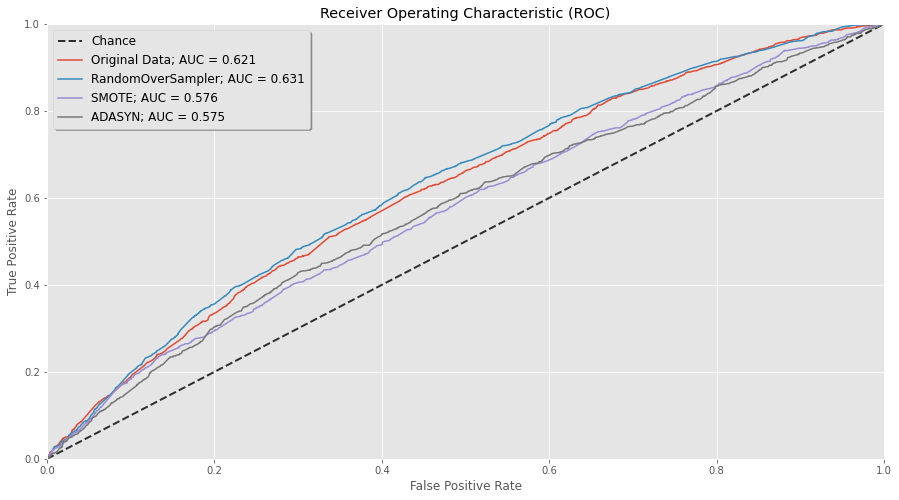

In [44]:
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

fig, ax = plt.subplots(1, 1, figsize=(15, 8), sharey=False)

ax.plot(
    [0, 1], [0, 1], 
    linestyle='--', 
    lw=2, color='k',
    label='Chance', alpha=.8
)

# Original Data

y_test, y_test_pred_proba = sample_and_predict(x_train, y_train, x_test, y_test, sampler=None)

plot_roc_curve(
    y_test, y_test_pred_proba, 
    label='Original Data',
    ax=ax
) 

# RandomOverSampler

ros = RandomOverSampler(random_state=42)

y_test, y_test_pred_proba = sample_and_predict(x_train, y_train, x_test, y_test, sampler=ros)

plot_roc_curve(
    y_test, y_test_pred_proba, 
    label='RandomOverSampler',
    ax=ax
)

# SMOTE 

smote = SMOTE(random_state=42)

y_test, y_test_pred_proba = sample_and_predict(x_train, y_train, x_test, y_test, sampler=smote)

plot_roc_curve(
    y_test, y_test_pred_proba, 
    label='SMOTE',
    ax=ax
) 


adasyn = ADASYN(random_state=42)

y_test, y_test_pred_proba = sample_and_predict(x_train, y_train, x_test, y_test, sampler=adasyn)

plot_roc_curve(
    y_test, y_test_pred_proba, 
    label='ADASYN',
    ax=ax
)


ax.set_title(f'Receiver Operating Characteristic (ROC)')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

ax.legend(ncol=1, fontsize='large', shadow=True)

fig.show()

# Combining data sampling with ensembles

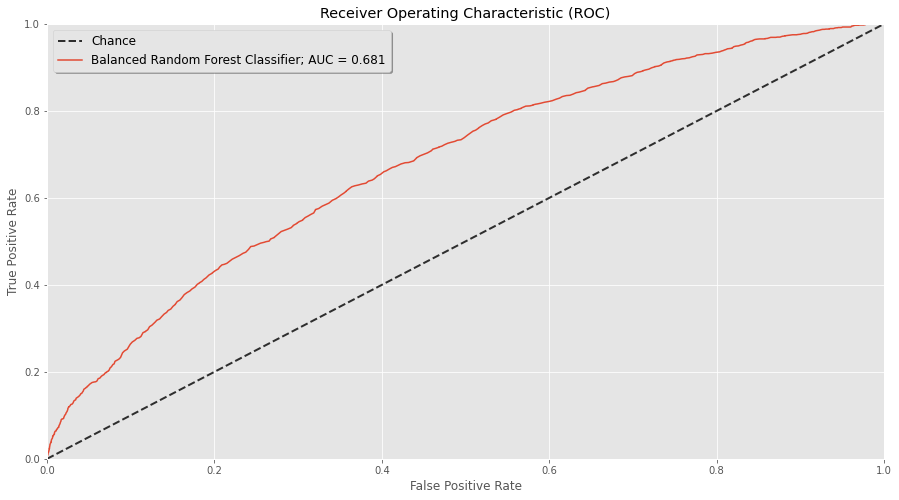

In [52]:
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier

fig, ax = plt.subplots(1, 1, figsize=(15, 8), sharey=False)

ax.plot(
    [0, 1], [0, 1], 
    linestyle='--', 
    lw=2, color='k',
    label='Chance', alpha=.8
)

# BalancedRandomForestClassifier

clf = BalancedRandomForestClassifier(
    n_estimators=500,  
    random_state=42
)

clf.fit(x_train, y_train)

y_test_pred_proba = clf.predict_proba(x_test)[:,1]

plot_roc_curve(
    y_test, y_test_pred_proba, 
    label='Balanced Random Forest Classifier',
    ax=ax
) 


# BalancedBaggingClassifier

# bbc = BalancedBaggingClassifier(
#     n_estimators=500, 
#     random_state=42
# )

# bbc.fit(x_train, y_train)

# y_test_pred_proba = bbc.predict_proba(x_test)[:,1]

# plot_roc_curve(
#     y_test, y_test_pred_proba, 
#     label='Balanced Bagging Classifier',
#     ax=ax
# ) 


ax.legend(ncol=1, fontsize='large', shadow=True)

ax.set_title(f'Receiver Operating Characteristic (ROC)')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

fig.show()